# Deep Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("max.columns", 30)
pd.set_option("max.rows", 100)
sns.set()

## Fetch data

In [3]:
data = pd.read_csv("data/train_1.csv.zip")
data = data.set_index("Page",drop=True).dropna(how="any").T
data.index = pd.to_datetime(data.index)
data.index.name = "ds"

### Inspect page visits

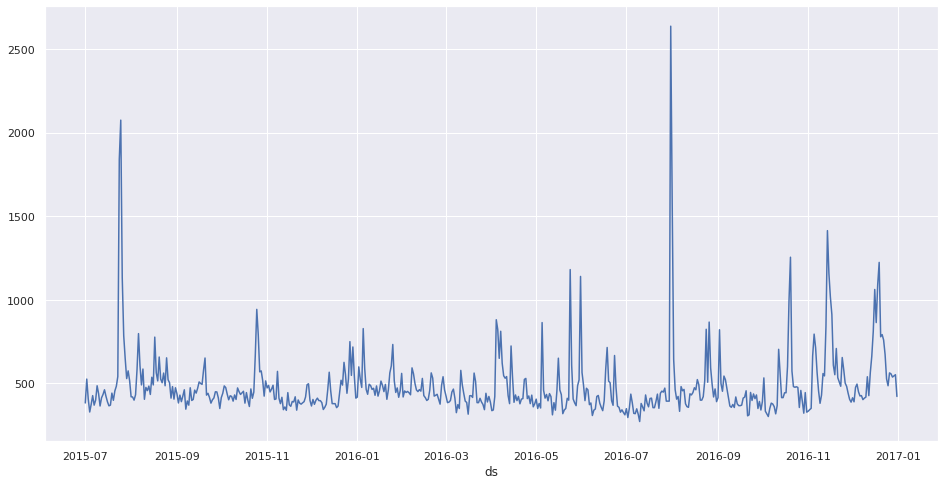

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
_ = sns.lineplot(x=data.index, y=data.iloc[:, 4007].values, ax=ax)

In [5]:
# take an example ts
ts = data.iloc[:, 4007].copy()
ts

ds
2015-07-01    383.0
2015-07-02    526.0
2015-07-03    407.0
2015-07-04    329.0
2015-07-05    375.0
              ...  
2016-12-27    557.0
2016-12-28    538.0
2016-12-29    545.0
2016-12-30    552.0
2016-12-31    422.0
Name: Jackie_Chan_fr.wikipedia.org_desktop_all-agents, Length: 550, dtype: float64

## Model building

In [6]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [93]:
# LSTM params
n_steps = 30
n_features = 1
units = 8

### Train/test split

In [12]:
def train_test_split(data, train_f=0.8):
    """
    data - time series
    train_f - fraction train
    """
    train_s = int(train_f * len(ts))
    train = ts[:train_s].values
    test = ts[train_s:].values
    return (train, test)


In [13]:
train, test = train_test_split(data, train_f=0.8)

### Scale data

In [14]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1,1))

### Format data/build generator

In [83]:
def build_seq_generators(data, n_steps, batch_size=1, val_f=0.2):
    """
    Produces generators for sequentially feeding time series data to the NN.
    
    data - ts train data of shape (tot # of time steps, n_features)
    n_steps - # of time steps to include in the LSTM time window
    n_features - # of features (additional time series)
    batch_size - # of samples in a single forward pass (should be 1)
    val_f - frac. of data to use for validation
    """
    val_start = int(data.shape[0] * (1 - val_f))

    # generator for training data
    train_gen = TimeseriesGenerator(
        data=data, 
        targets=data, 
        length=n_steps,
        sampling_rate=1, 
        stride=1,
        batch_size=batch_size,
        end_index=val_start - 1
    )

    # generator for test data
    val_gen = TimeseriesGenerator(
        data=data, 
        targets=data, 
        length=n_steps,
        sampling_rate=1, 
        stride=1,
        batch_size=batch_size,
        start_index=val_start - n_steps
    )

    return train_gen, val_gen

def build_network(units, n_steps, n_features, stateful=True, optimizer="adam", loss="mse"):
    model = Sequential()
    if stateful:
        model.add(LSTM(units, input_shape=(n_steps, n_features), batch_size=1, stateful=True))
    else:
        model.add(LSTM(units, input_shape=(n_steps, n_features)))
    
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model

def train_model(model, train_gen, val_gen=None, epochs=100):
    # reset LSTM state between each epoch
    for e in range(epochs):
        print("Epoch {}/{}".format(e + 1, epochs))
        model.fit_generator(train_gen,
                         steps_per_epoch=len(train_gen),
                         epochs=1, 
                         verbose=2,
                         validation_data=val_gen,
                         validation_steps=len(val_gen),
                         callbacks=[
                             EarlyStopping(patience=5, verbose=1),
                             ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)
                         ],
                         shuffle=False)
        # end of the series, reset LSTM state
        model.reset_states()
    return None

def generate_sequence(model, seed, n_steps, size):
    """
    model - trained LSTM model
    seed - seed sequence for genereting time series (n_steps, n_features)
    n_steps - # of time steps in the LSTM model
    size - # of future time steps to predict
    """
    predictions = list(seed.flatten())
    model.reset_states()
    # build up state using the seed sequence
    for i in range(len(seed) - n_steps):
        # prepare input data
        x = np.array(predictions)[i:(i + n_steps)]
        x = x.reshape(1, n_steps, 1)
        # update state
        _ = model.predict(x)

    # generate future values (past the seed sequence)
    for i in range(size):
        # prepare input data
        x = np.array(predictions)[-n_steps::]
        x = x.reshape(1, n_steps, 1)
        # make predictions
        y = model.predict(x)
        predictions.append(y[0,0])

    # reset model state
    model.reset_states()
    
    return np.array(predictions)


In [94]:
train_gen, val_gen = build_seq_generators(train_scaled, n_steps)

In [95]:
# check correctness
print("train gen. length: ", len(train_gen))
print("val.gen length: ", len(val_gen))

train gen. length:  322
val.gen length:  88


In [96]:
train_gen[0]

(array([[[0.04693446],
         [0.10739958],
         [0.05708245],
         [0.02410148],
         [0.0435518 ],
         [0.06553911],
         [0.04143763],
         [0.05412262],
         [0.09048626],
         [0.07061311],
         [0.03932347],
         [0.06004228],
         [0.06849894],
         [0.08033827],
         [0.06384778],
         [0.04989429],
         [0.0397463 ],
         [0.04143763],
         [0.07188161],
         [0.05369979],
         [0.07737844],
         [0.08921776],
         [0.11374207],
         [0.66300211],
         [0.76236786],
         [0.3640592 ],
         [0.21733615],
         [0.1589852 ],
         [0.10866808],
         [0.12811839]]]),
 array([[0.10317125]]))

The begining of the validation set is 1 time step ahead of the train set (and not the whole window). This is important because we are preserving the state in the LSTM layer which is meaningful only for the subsequent time step (if we skipped the whole window the inputs would not match the internal state) 

In [97]:
model = build_network(units, n_steps, n_features, stateful=False)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model, train_gen, epochs=100, val_gen=val_gen)

Epoch 1/100
Epoch 1/1
 - 6s - loss: 0.0033 - val_loss: 0.0026
Epoch 2/100
Epoch 1/1
 - 5s - loss: 0.0027 - val_loss: 0.0021
Epoch 3/100
Epoch 1/1
 - 5s - loss: 0.0025 - val_loss: 0.0018
Epoch 4/100
Epoch 1/1
 - 5s - loss: 0.0024 - val_loss: 0.0016
Epoch 5/100
Epoch 1/1
 - 5s - loss: 0.0023 - val_loss: 0.0014
Epoch 6/100
Epoch 1/1
 - 5s - loss: 0.0023 - val_loss: 0.0013
Epoch 7/100
Epoch 1/1
 - 5s - loss: 0.0022 - val_loss: 0.0012
Epoch 8/100
Epoch 1/1
 - 5s - loss: 0.0022 - val_loss: 0.0011
Epoch 9/100
Epoch 1/1
 - 5s - loss: 0.0022 - val_loss: 9.9133e-04
Epoch 10/100
Epoch 1/1
 - 5s - loss: 0.0022 - val_loss: 9.2445e-04
Epoch 11/100
Epoch 1/1
 - 5s - loss: 0.0021 - val_loss: 8.7163e-04
Epoch 12/100
Epoch 1/1
 - 5s - loss: 0.0021 - val_loss: 8.3065e-04
Epoch 13/100
Epoch 1/1
 - 5s - loss: 0.0021 - val_loss: 7.9946e-04
Epoch 14/100
Epoch 1/1
 - 5s - loss: 0.0021 - val_loss: 7.7629e-04
Epoch 15/100
Epoch 1/1
 - 5s - loss: 0.0021 - val_loss: 7.5970e-04
Epoch 16/100
Epoch 1/1
 - 5s - loss:

### Evaluate model

In [91]:
seed = train_scaled[:n_steps,:]
predictions = generate_sequence(model, seed, n_steps, len(train_scaled) - len(seed) - n_steps)

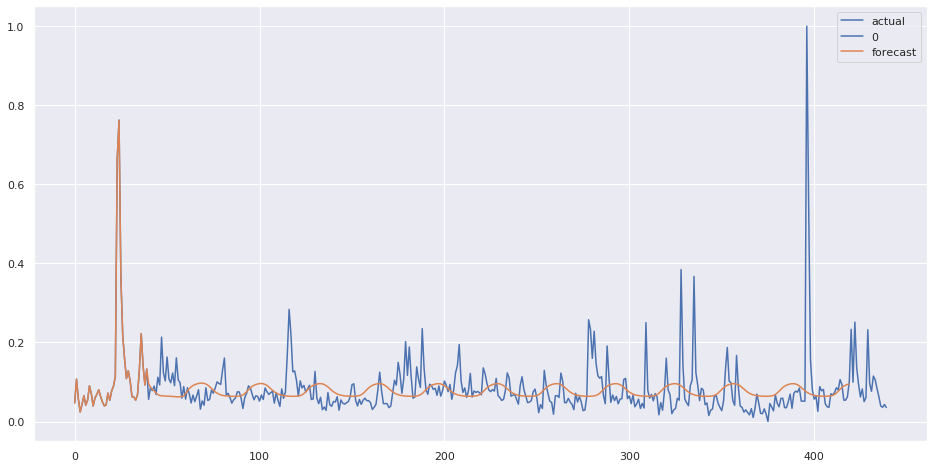

In [92]:
fig, ax = plt.subplots(figsize=(16, 8))
_ = sns.lineplot(data=train_scaled, label="actual", ax=ax)
_ = sns.lineplot(data=predictions, label="forecast", ax=ax)